# Item Item Scorer

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from lenskit.basic import topn
from lenskit.knn import ItemKNNScorer
from lenskit.batch import recommend
from lenskit.data import from_interactions_df, ItemListCollection, UserIDKey
from lenskit.metrics import NDCG, RBP, RecipRank, RunAnalysis, Recall, Precision, RMSE, MAE
from lenskit.pipeline import topn_pipeline
from lenskit.splitting import SampleFrac, crossfold_users

Load data

In [4]:
df = pd.read_csv('../ALS/data/ratings.csv')
books_df = pd.read_csv('../ALS/data/books.csv')
dataset = from_interactions_df(df, user_col='user_id', item_col='book_id', rating_col='rating')

## Build ItemItem Model

Build model with default settings

In [3]:
model_ii = ItemKNNScorer(k=20)

In [4]:
pipe_ii = topn_pipeline(model_ii)

In [5]:
# test data is organized by user
all_test = ItemListCollection(UserIDKey)
# recommendations will be organized by model and user ID
all_recs = ItemListCollection(["model", "user_id"])

for split in crossfold_users(dataset, 5, SampleFrac(0.2)):
    # collect the test data
    all_test.add_from(split.test)

    # train the pipeline, cloning first so a fresh pipeline for each split
    fit_ii = pipe_ii.clone()
    fit_ii.train(split.train)
    ii_recs = recommend(fit_ii, split.test.keys(), 100)
    all_recs.add_from(ii_recs, model="II")

/opt/miniconda3/envs/dvC_env/lib/python3.13/site-packages/lenskit/data/relationships.py:378: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /Users/runner/miniforge3/conda-bld/libtorch_1741947719636/work/aten/src/ATen/SparseCsrTensorImpl.cpp:55.)
  return torch.sparse_csr_tensor(


In [6]:
ran = RunAnalysis()
ran.add_metric(NDCG())
ran.add_metric(RBP())
ran.add_metric(RecipRank())
results = ran.measure(all_recs, all_test)

In [8]:
results.list_metrics().mean()

NDCG         0.015468
RBP          0.007261
RecipRank    0.026249
dtype: float64

First Fine Tuning. Increase min neighbours from 1 to 3 and increase minimum similarity from 1e-06 to 0.1

In [9]:
model_ii = ItemKNNScorer(
    max_nbrs=20,              # 20 Nachbarn
    min_nbrs=3,            # Mindestens 3 Nachbarn
    min_sim=0.1             # Mindest-Ähnlichkeit
    )
pipe_ii = topn_pipeline(model_ii)

In [10]:
# test data is organized by user
all_test = ItemListCollection(UserIDKey)
# recommendations will be organized by model and user ID
all_recs = ItemListCollection(["model", "user_id"])

for split in crossfold_users(dataset, 5, SampleFrac(0.2)):
    # collect the test data
    all_test.add_from(split.test)

    # train the pipeline, cloning first so a fresh pipeline for each split
    fit_ii = pipe_ii.clone()
    fit_ii.train(split.train)
    ii_recs = recommend(fit_ii, split.test.keys(), 100)
    all_recs.add_from(ii_recs, model="II")

Tests mit k=10

In [ ]:
ran = RunAnalysis()
ran.add_metric(NDCG())
ran.add_metric(Precision())
ran.add_metric(Recall())
ran.add_metric(RBP())
ran.add_metric(RecipRank())
ran.add_metric(RMSE(missing_scores='ignore', missing_truth='ignore'))
ran.add_metric(MAE(missing_scores='ignore', missing_truth='ignore'))
results = ran.measure(all_recs, all_test)

In [20]:
results.list_metrics().mean()

NDCG@10         0.179640
Precision@10    0.179530
Recall@10       0.175635
RBP             0.170473
RecipRank       0.350592
RMSE            0.187708
MAE             0.050603
dtype: float64

Grid Search

In [4]:
# Schnelle Parameter-Suche
configs = [
    {"max_nbrs": 20, "min_nbrs": 3, "min_sim": 0.1},   # Current
    {"max_nbrs": 30, "min_nbrs": 5, "min_sim": 0.2},   # Konservativer
    {"max_nbrs": 50, "min_nbrs": 3, "min_sim": 0.15},  # Mehr Nachbarn
    {"max_nbrs": 40, "min_nbrs": 2, "min_sim": 0.05},  # Liberal

    # Zusätzliche Tests:
    {"max_nbrs": 10, "min_nbrs": 2, "min_sim": 0.3},   # Sehr konservativ
    {"max_nbrs": 100, "min_nbrs": 5, "min_sim": 0.1},  # Viele Nachbarn
    {"max_nbrs": 15, "min_nbrs": 1, "min_sim": 0.4},   # Hohe Ähnlichkeit
    {"max_nbrs": 80, "min_nbrs": 1, "min_sim": 0.01},  # Sehr liberal
    {"max_nbrs": 25, "min_nbrs": 3, "min_sim": 0.25},  # Balanced+
    {"max_nbrs": 60, "min_nbrs": 8, "min_sim": 0.15},  # Viele min_nbrs
]

for i, config in enumerate(configs):
    print(f"Testing config {i+1}: {config}")

    model_ii = ItemKNNScorer(**config)
    pipe_ii = topn_pipeline(model_ii)

    # test data is organized by user
    all_test = ItemListCollection(UserIDKey)
    # recommendations will be organized by model and user ID
    all_recs = ItemListCollection(["model", "user_id"])

    for split in crossfold_users(dataset, 1, SampleFrac(0.2)):
        # collect the test data
        all_test.add_from(split.test)

        # do the same for item-item
        fit_ii = pipe_ii.clone()
        fit_ii.train(split.train)
        ii_recs = recommend(fit_ii, split.test.keys(), 100)
        all_recs.add_from(ii_recs, model="II")
    
    ran = RunAnalysis()
    ran.add_metric(NDCG())
    ran.add_metric(RBP())
    ran.add_metric(RecipRank())
    ran.add_metric(Precision())
    ran.add_metric(Recall())
    results = ran.measure(all_recs, all_test)

    print(results.list_metrics().groupby("model").mean())

Testing config 1: {'max_nbrs': 20, 'min_nbrs': 3, 'min_sim': 0.1}


/opt/miniconda3/envs/dvC_env/lib/python3.13/site-packages/lenskit/data/relationships.py:378: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /Users/runner/miniforge3/conda-bld/libtorch_1741947719636/work/aten/src/ATen/SparseCsrTensorImpl.cpp:55.)
  return torch.sparse_csr_tensor(


           NDCG       RBP  RecipRank  Precision    Recall
model                                                    
II     0.237436  0.198387   0.395506   0.184912  0.269934
Testing config 2: {'max_nbrs': 30, 'min_nbrs': 5, 'min_sim': 0.2}
         NDCG       RBP  RecipRank  Precision    Recall
model                                                  
II     0.1116  0.135806   0.363094   0.284141  0.067372
Testing config 3: {'max_nbrs': 50, 'min_nbrs': 3, 'min_sim': 0.15}
           NDCG       RBP  RecipRank  Precision    Recall
model                                                    
II     0.197632  0.210053   0.471622   0.273778  0.166232
Testing config 4: {'max_nbrs': 40, 'min_nbrs': 2, 'min_sim': 0.05}
           NDCG       RBP  RecipRank  Precision    Recall
model                                                    
II     0.108927  0.035357   0.107426   0.043027  0.199847
Testing config 5: {'max_nbrs': 10, 'min_nbrs': 2, 'min_sim': 0.3}
           NDCG      RBP  RecipRank  Precisi

Config 1 ist vorzuziehen.

Top 3 Configs:
1. Config 1 max_nbrs=20, min_nbrs=3, min_sim=0.1

NDCG: 0.237 (Beste Ranking-Qualität)
Recall: 0.270 (Findet viele relevante Items)
Ausgewogene Performance

2. Config 3 max_nbrs=50, min_nbrs=3, min_sim=0.15

NDCG: 0.198, Precision: 0.274 (Hohe Precision)
Guter Kompromiss zwischen Qualität und Abdeckung

3. Config 5 max_nbrs=10, min_nbrs=2, min_sim=0.3

Precision: 0.357 (Beste Precision!)
Aber niedriger Recall (0.115)

In [5]:
model_ii = ItemKNNScorer(
    max_nbrs=20,              # 50 Nachbarn
    min_nbrs=3,               # Mindestens 3 Nachbarn
    min_sim=0.11              # Mindest-Ähnlichkeit
    )
pipe_ii = topn_pipeline(model_ii)
# pipe_ii.train(dataset)
# recs = recommend(pipe_ii, [234], 100)

In [11]:
# test data is organized by user
all_test = ItemListCollection(UserIDKey)
# recommendations will be organized by model and user ID
all_recs = ItemListCollection(["model", "user_id"])

for split in crossfold_users(dataset, 5, SampleFrac(0.2)):
    # collect the test data
    all_test.add_from(split.test)

    # train the pipeline, cloning first so a fresh pipeline for each split
    fit_ii = pipe_ii.clone()
    fit_ii.train(split.train)
    ii_recs = recommend(fit_ii, split.test.keys(), 100)
    all_recs.add_from(ii_recs, model="II")

KeyboardInterrupt: 

In [7]:
ran = RunAnalysis()

# Alle k-Werte von 1 bis 20 hinzufügen
k_values = range(1, 21)
for k in k_values:
    ran.add_metric(NDCG(k=k))
    ran.add_metric(Precision(k=k))
    ran.add_metric(Recall(k=k))
    ran.add_metric(RBP(k=k))
    ran.add_metric(RecipRank(k=k))

# Einmal ausführen für alle Metriken
results = ran.measure(all_recs, all_test)
df_results = results.list_metrics().groupby("model").mean()

print(df_results)

         NDCG@1  Precision@1  Recall@1     RBP@1  RecipRank@1    NDCG@2  \
model                                                                     
II     0.193677     0.193677  0.193677  0.029052     0.193677  0.212311   

       Precision@2  Recall@2     RBP@2  RecipRank@2  ...  NDCG@19  \
model                                                ...            
II        0.213312  0.212311  0.058497      0.27892  ...  0.18869   

       Precision@19  Recall@19    RBP@19  RecipRank@19   NDCG@20  \
model                                                              
II         0.189599   0.177987  0.184925      0.379169  0.188186   

       Precision@20  Recall@20    RBP@20  RecipRank@20  
model                                                   
II         0.188373   0.177699  0.185752      0.379434  

[1 rows x 100 columns]


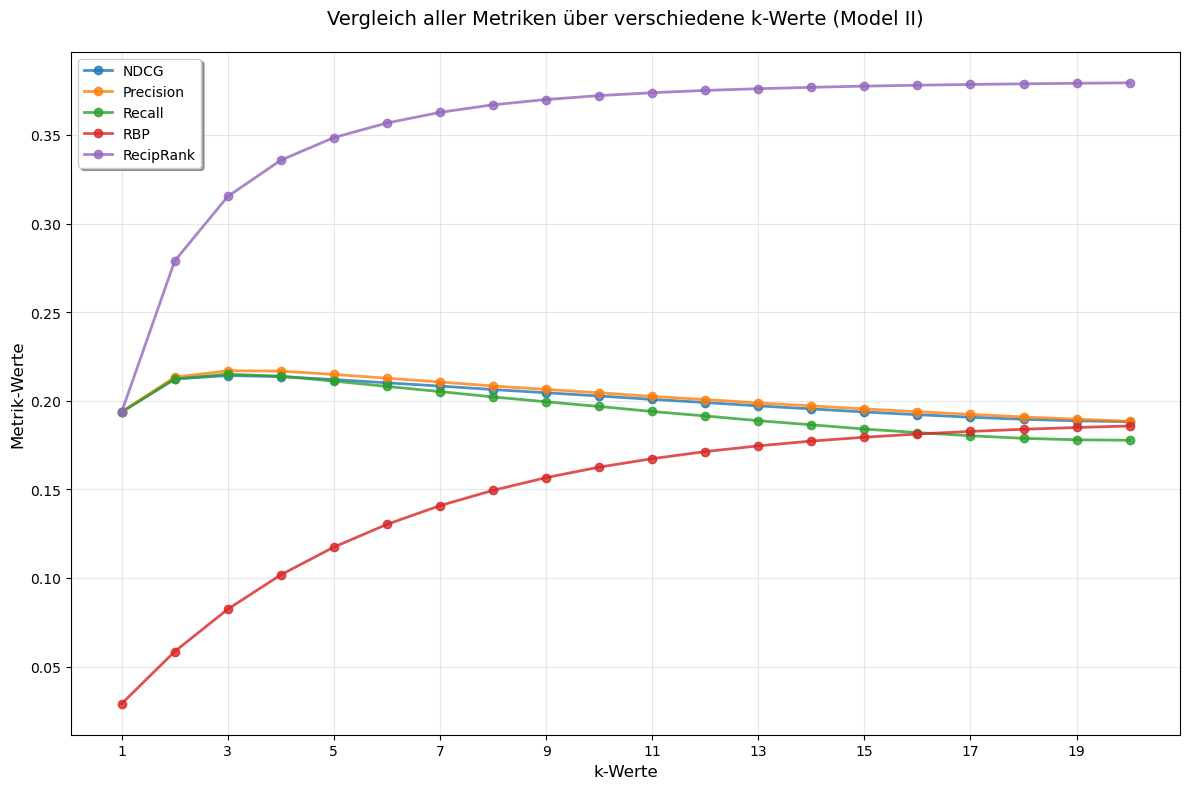

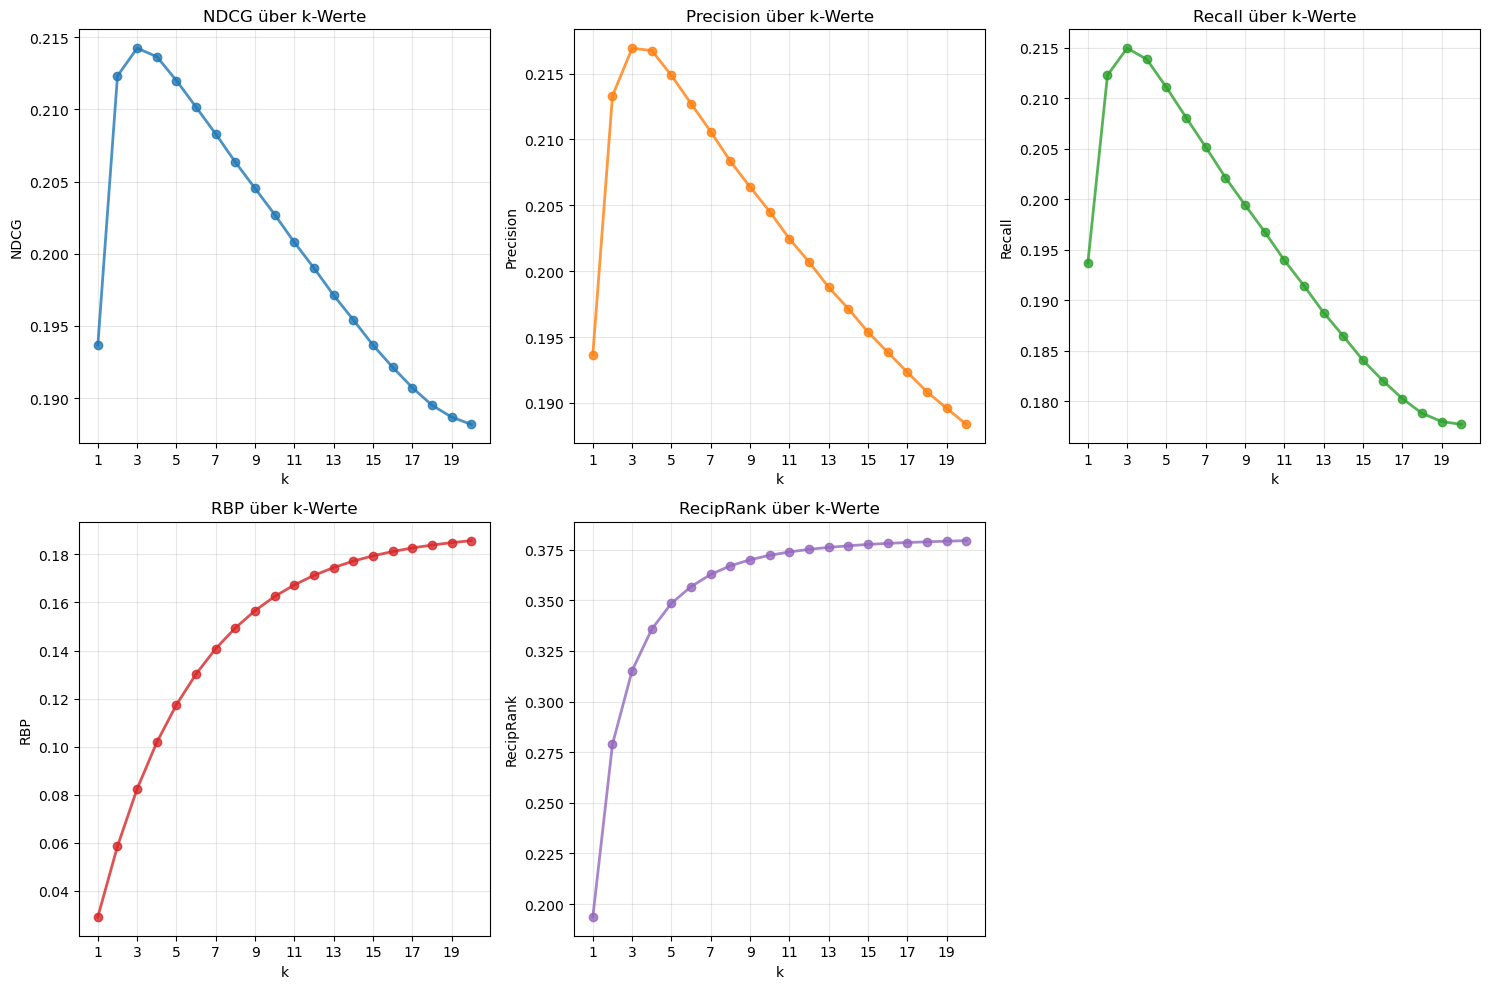

In [13]:
# Extrahiere die Metriken für den Plot
model_row = df_results.iloc[0]  # Erste (und einzige) Zeile für Model II

# Separiere die verschiedenen Metriken
metrics = ['NDCG', 'Precision', 'Recall', 'RBP', 'RecipRank']
k_values = range(1, 21)

# Erstelle ein Dictionary für jede Metrik
metric_data = {}
for metric in metrics:
    metric_data[metric] = []
    for k in k_values:
        column_name = f"{metric}@{k}"
        if column_name in model_row.index:
            metric_data[metric].append(model_row[column_name])
        else:
            metric_data[metric].append(np.nan)

# Erstelle den Plot
plt.figure(figsize=(12, 8))

# Definiere Farben für jede Metrik
colors = {
    'NDCG': '#1f77b4',      # Blau
    'Precision': '#ff7f0e',  # Orange
    'Recall': '#2ca02c',     # Grün
    'RBP': '#d62728',        # Rot
    'RecipRank': '#9467bd'   # Lila
}

# Plotte jede Metrik
for metric in metrics:
    plt.plot(k_values, metric_data[metric], 
             marker='o', linewidth=2, markersize=6,
             color=colors[metric], label=metric, alpha=0.8)

# Formatierung
plt.xlabel('k-Werte', fontsize=12)
plt.ylabel('Metrik-Werte', fontsize=12)
plt.title('Vergleich aller Metriken über verschiedene k-Werte (Model II)', fontsize=14, pad=20)
plt.legend(loc='best', frameon=True, fancybox=True, shadow=True)
plt.grid(True, alpha=0.3)
plt.xticks(k_values[::2])  # Zeige jeden zweiten k-Wert auf der x-Achse

# Verbessere das Layout
plt.tight_layout()
plt.show()

# Optional: Zusätzlicher Plot mit Subplots für bessere Lesbarkeit
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    axes[i].plot(k_values, metric_data[metric], 
                marker='o', linewidth=2, markersize=6,
                color=colors[metric], alpha=0.8)
    axes[i].set_title(f'{metric} über k-Werte', fontsize=12)
    axes[i].set_xlabel('k')
    axes[i].set_ylabel(metric)
    axes[i].grid(True, alpha=0.3)
    axes[i].set_xticks(k_values[::2])

# Entferne den letzten leeren Subplot
axes[-1].remove()

plt.tight_layout()
plt.show()


SHow metrics of better perfoming model (but bad in praxis)

In [20]:
model_ii = ItemKNNScorer(
    max_nbrs=22,              # 50 Nachbarn
    min_nbrs=4,               # Mindestens 3 Nachbarn
    min_sim=0.22              # Mindest-Ähnlichkeit
    )
pipe_ii = topn_pipeline(model_ii)

In [21]:
# test data is organized by user
all_test = ItemListCollection(UserIDKey)
# recommendations will be organized by model and user ID
all_recs = ItemListCollection(["model", "user_id"])

for split in crossfold_users(dataset, 5, SampleFrac(0.2)):
    # collect the test data
    all_test.add_from(split.test)

    # train the pipeline, cloning first so a fresh pipeline for each split
    fit_ii = pipe_ii.clone()
    fit_ii.train(split.train)
    ii_recs = recommend(fit_ii, split.test.keys(), 100)
    all_recs.add_from(ii_recs, model="II")

In [22]:
ran = RunAnalysis()

# Alle k-Werte von 1 bis 20 hinzufügen
k_values = range(1, 21)
for k in k_values:
    ran.add_metric(NDCG(k=k))
    ran.add_metric(Precision(k=k))
    ran.add_metric(Recall(k=k))
    ran.add_metric(RBP(k=k))
    ran.add_metric(RecipRank(k=k))

# Einmal ausführen für alle Metriken
results = ran.measure(all_recs, all_test)
df_results = results.list_metrics().groupby("model").mean()

print(df_results)

         NDCG@1  Precision@1  Recall@1     RBP@1  RecipRank@1    NDCG@2  \
model                                                                     
II     0.358678     0.358678  0.358678  0.053802     0.358678  0.321092   

       Precision@2  Recall@2     RBP@2  RecipRank@2  ...   NDCG@19  \
model                                                ...             
II        0.346165  0.321092  0.089949     0.402226  ...  0.162441   

       Precision@19  Recall@19  RBP@19  RecipRank@19   NDCG@20  Precision@20  \
model                                                                          
II         0.305465   0.112258  0.1757      0.430299  0.159383      0.305209   

       Recall@20    RBP@20  RecipRank@20  
model                                     
II      0.108996  0.175852      0.430311  

[1 rows x 100 columns]


In [19]:
df_results.T.to_clipboard()

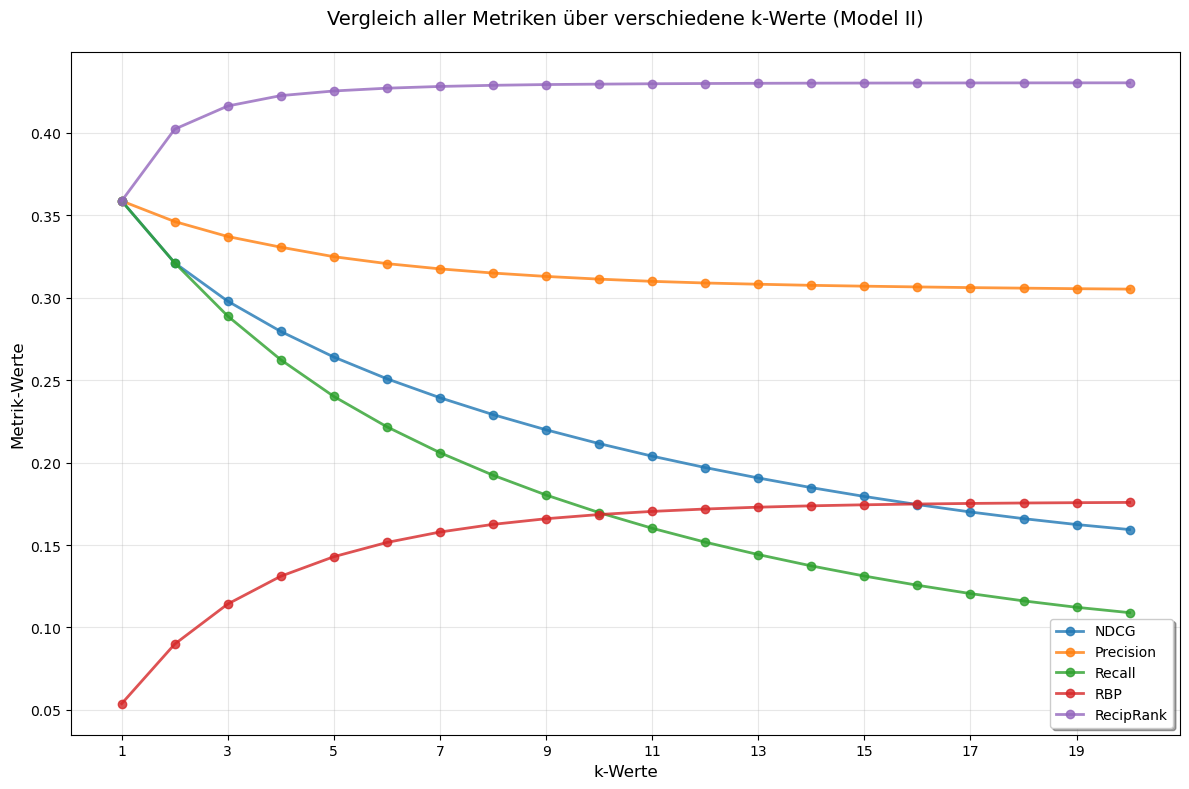

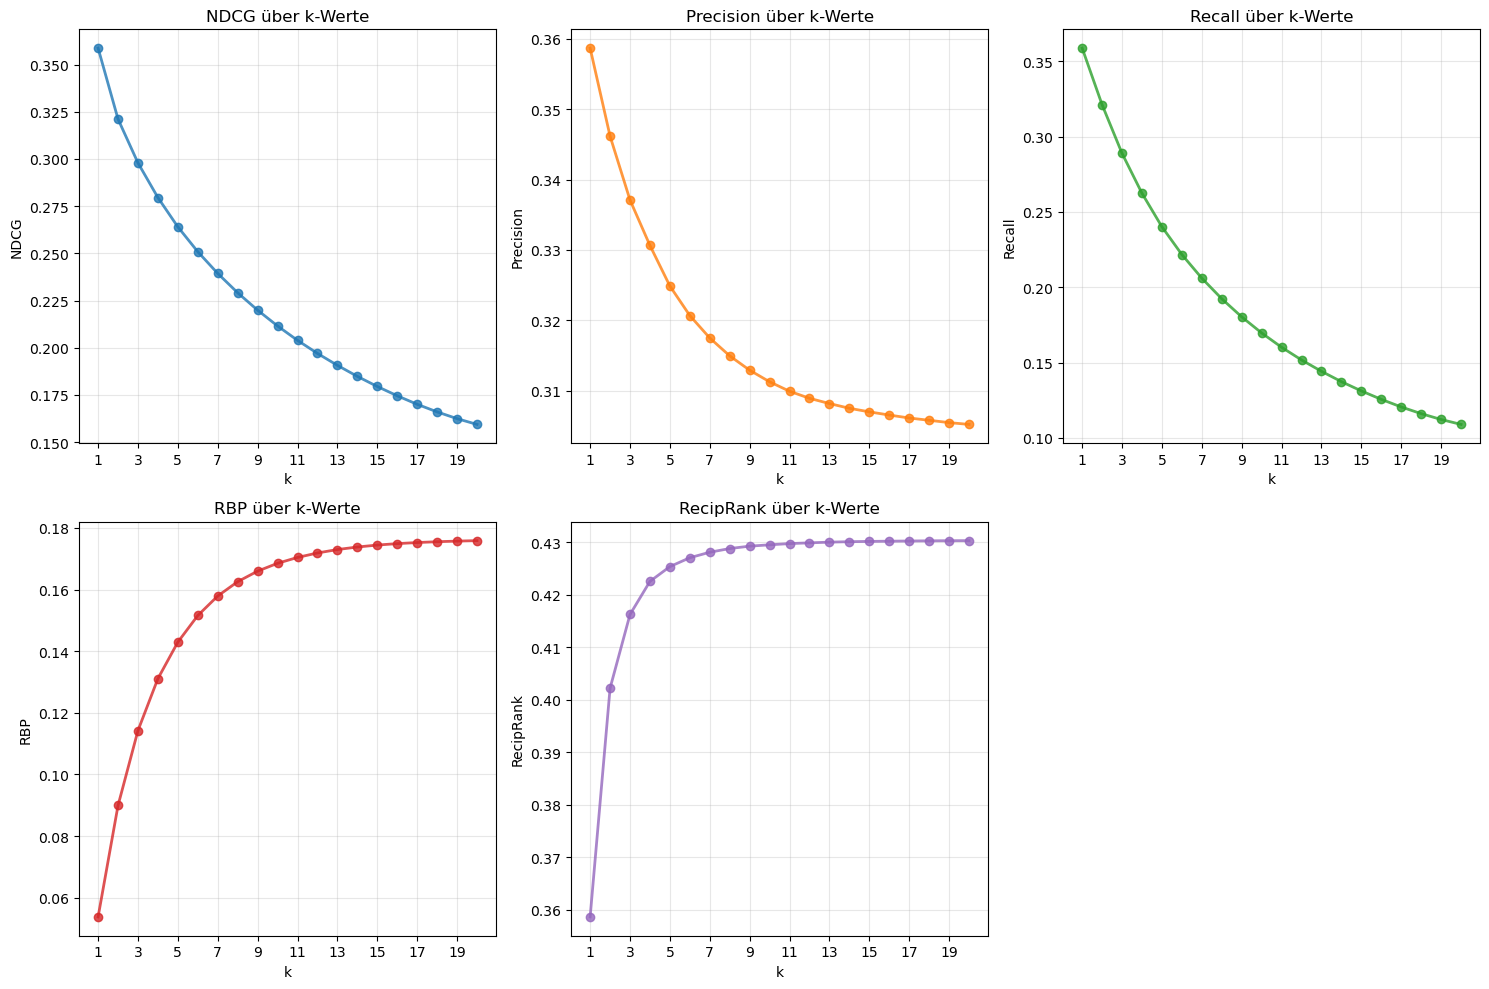

In [23]:
# Extrahiere die Metriken für den Plot
model_row = df_results.iloc[0]  # Erste (und einzige) Zeile für Model II

# Separiere die verschiedenen Metriken
metrics = ['NDCG', 'Precision', 'Recall', 'RBP', 'RecipRank']
k_values = range(1, 21)

# Erstelle ein Dictionary für jede Metrik
metric_data = {}
for metric in metrics:
    metric_data[metric] = []
    for k in k_values:
        column_name = f"{metric}@{k}"
        if column_name in model_row.index:
            metric_data[metric].append(model_row[column_name])
        else:
            metric_data[metric].append(np.nan)

# Erstelle den Plot
plt.figure(figsize=(12, 8))

# Definiere Farben für jede Metrik
colors = {
    'NDCG': '#1f77b4',      # Blau
    'Precision': '#ff7f0e',  # Orange
    'Recall': '#2ca02c',     # Grün
    'RBP': '#d62728',        # Rot
    'RecipRank': '#9467bd'   # Lila
}

# Plotte jede Metrik
for metric in metrics:
    plt.plot(k_values, metric_data[metric], 
             marker='o', linewidth=2, markersize=6,
             color=colors[metric], label=metric, alpha=0.8)

# Formatierung
plt.xlabel('k-Werte', fontsize=12)
plt.ylabel('Metrik-Werte', fontsize=12)
plt.title('Vergleich aller Metriken über verschiedene k-Werte (Model II)', fontsize=14, pad=20)
plt.legend(loc='best', frameon=True, fancybox=True, shadow=True)
plt.grid(True, alpha=0.3)
plt.xticks(k_values[::2])  # Zeige jeden zweiten k-Wert auf der x-Achse

# Verbessere das Layout
plt.tight_layout()
plt.show()

# Optional: Zusätzlicher Plot mit Subplots für bessere Lesbarkeit
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    axes[i].plot(k_values, metric_data[metric], 
                marker='o', linewidth=2, markersize=6,
                color=colors[metric], alpha=0.8)
    axes[i].set_title(f'{metric} über k-Werte', fontsize=12)
    axes[i].set_xlabel('k')
    axes[i].set_ylabel(metric)
    axes[i].grid(True, alpha=0.3)
    axes[i].set_xticks(k_values[::2])

# Entferne den letzten leeren Subplot
axes[-1].remove()

plt.tight_layout()
plt.show()
